###Data Loading

Add the ec2_cpu_utilization csv file to the workspace before running the code.

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.3/838.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from scipy.ndimage import maximum_filter1d, minimum_filter1d

# Configuration
config = {
    'mode': 'train',  # Options: 'train' or 'test'
    'window_length': 2,
    'gpu_id': 0,
    'learning_rate': 1e-3,
    'epochs': 100,
    'batch_size': 16,
    'num_workers': 0,
    'seed': 100,
    'dataset_path': '/content/ec2_cpu_utilization_24ae8d.csv',
    'log_dir': '/content/logs',
    'checkpoint_path': '',
    'transformation_list': ["low_pass", "high_pass", "dilation", "erosion", "identity"]
}

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(config['gpu_id'])

# Seed for reproducibility
random.seed(config['seed'])
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config['seed'])

In [ ]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from scipy.ndimage import maximum_filter1d, minimum_filter1d
import random

class EC2CPUUtilizationDataset(Dataset):
    """EC2 CPU Utilization Dataset for anomaly detection"""
    def __init__(self, file_path, win_len=64, transformation_list=None, train=True):
        self.file_path = file_path
        self.win_len = win_len
        self.transformation_list = transformation_list or ["low_pass", "high_pass", "dilation", "erosion", "identity"]
        self.num_classes = len(self.transformation_list)
        self.traces = self.load_data()

    def load_data(self):
        data = pd.read_csv(self.file_path, parse_dates=['timestamp'], index_col='timestamp')
        values = data['value'].values
        traces = [values[i:i + self.win_len] for i in range(len(values) - self.win_len)]
        return traces

    def transform_win(self, win):
        trans_win = torch.FloatTensor(win)
        trans_win = trans_win.unsqueeze(0)  # Make it 3D for model compatibility
        return trans_win

    def __len__(self):
        return len(self.traces)

    def __getitem__(self, idx):
        tracedata = self.traces[idx]
        orig_win = tracedata.copy()
        trans_win = tracedata.copy()

        transform_id = random.randint(0, self.num_classes - 1)
        if self.transformation_list[transform_id] == "low_pass":
            trans_win = self.apply_filter_on_1D_data(trans_win, [1/3, 1/3, 1/3])
        elif self.transformation_list[transform_id] == "high_pass":
            trans_win = self.apply_filter_on_1D_data(trans_win, [-1/2, 0, 1/2])
        elif self.transformation_list[transform_id] == "dilation":
            trans_win = self.apply_dilation(trans_win, filter_size=3)
        elif self.transformation_list[transform_id] == "erosion":
            trans_win = self.apply_erosion(trans_win, filter_size=3)

        # Adjust the length of trans_win to match win_len
        trans_win = self.adjust_length(trans_win)

        # Convert to tensors and reshape
        trans_win = self.transform_win(trans_win)
        orig_win = self.transform_win(orig_win)

        return orig_win, trans_win, transform_id

    def adjust_length(self, sequence):
        """Adjust sequence length to match win_len by padding or truncating."""
        sequence = np.array(sequence)
        if len(sequence) < self.win_len:
            # Pad with the last value if sequence is too short
            padding = np.full(self.win_len - len(sequence), sequence[-1])
            sequence = np.concatenate([sequence, padding])
        elif len(sequence) > self.win_len:
            # Truncate if sequence is too long
            sequence = sequence[:self.win_len]
        return sequence

    def apply_filter_on_1D_data(self, input_data, filter_coeffs):
        input_data = np.array(input_data).flatten()
        return np.convolve(input_data, filter_coeffs, 'same')

    def apply_dilation(self, input_data, filter_size):
        return maximum_filter1d(input_data, size=filter_size, mode='nearest')

    def apply_erosion(self, input_data, filter_size):
        return minimum_filter1d(input_data, size=filter_size, mode='nearest')


In [ ]:
dataset = EC2CPUUtilizationDataset(
        file_path=config['dataset_path'],
        win_len=config['window_length'],
        transformation_list=config['transformation_list']
    )

In [ ]:
sample_orig, sample_trans, _ = dataset[0]
input_dim = sample_orig.shape[1]  # Automatically derived from dataset sample
print(input_dim)

2


### Model Definition

In [ ]:
import torch
import torch.nn as nn

# Dynamically adapt model dimensions based on data input shape
class EncBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(EncBlock, self).__init__()
        self.layers = nn.Sequential(nn.Linear(in_features, out_features))

    def forward(self, x):
        out = self.layers(x)
        return torch.cat([x, out], dim=-1)  # Concatenate along the last dimension

class LeNet5(nn.Module):
    def __init__(self, n_classes, in_feat):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_feat, 120), nn.Tanh())
        self.layer2 = nn.Linear(120, 84)
        self.enc = EncBlock(in_features=84, out_features=84)

    def forward(self, x):
        # Process input through the layers
        x = self.layer1(x)  # Shape: [batch_size, 120]
        x = self.layer2(x)  # Shape: [batch_size, 84]

        # Ensure enc outputs 2 * enc_dim features
        feat = self.enc(x)  # Shape: [batch_size, 84 + 84 = 168]

        # Split `feat` into `mu` and `logvar`
        enc_dim = feat.shape[-1] // 2
        mu = feat[:, :enc_dim]     # Shape: [batch_size, 84]
        logvar = feat[:, enc_dim:]  # Shape: [batch_size, 84]

        # Compute `std` and sample using the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std * 0.001).add_(mu)

class Regressor(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Regressor, self).__init__()
        self.lenet = LeNet5(n_classes=num_classes, in_feat=input_dim)
        self.fc1 = nn.Linear(84 * 2, 42)  # Adjusted to match the output shape of LeNet5 * 2 for concatenation
        self.fc2 = nn.Linear(42, num_classes)

    def forward(self, x1, x2,last=False):
        # Pass each input through the LeNet5
        x1 = x1.view(x1.size(0), -1)
        x2= x2.view(x2.size(0), -1)
        x1 = self.lenet(x1)  # Shape: [batch_size, 84]
        x2 = self.lenet(x2)  # Shape: [batch_size, 84]
        # Concatenate the two outputs from LeNet5
        x = torch.cat((x1, x2), dim=1)  # Shape: [batch_size, 84 * 2 = 168]
        #print(x.shape)
        # Pass through fully connected layers
        x = torch.relu(self.fc1(x))  # Shape: [batch_size, 42]
        #print(x.shape)
        if(last):
            return x,self.fc2(x)  # Shape: [batch_size, num_classes]
        return self.fc2(x)  # Shape: [batch_size, num_classes]


In [ ]:
model = Regressor(input_dim=input_dim, num_classes=len(config['transformation_list'])).to(device)
if config['checkpoint_path']:
    model.load_state_dict(torch.load(config['checkpoint_path']))

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'])
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'])

In [ ]:
for orig_data, trans_data, label in train_dataloader:
    print(orig_data.shape)
    print(trans_data.shape)
    print(label.shape)
    break

torch.Size([16, 1, 2])
torch.Size([16, 1, 2])
torch.Size([16])


In [ ]:
# Main script
if __name__ == '__main__':
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    # Training loop
    for epoch in range(1, config['epochs'] + 1):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for orig_data, trans_data, label in train_dataloader:
            orig_data, trans_data, label = orig_data.to(device), trans_data.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(orig_data, trans_data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(output, dim=1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

        avg_loss = total_loss / len(train_dataloader)
        accuracy = 100 * correct_predictions / total_samples

        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{config['epochs']}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [10/100], Loss: 0.4088, Accuracy: 79.56%
Epoch [20/100], Loss: 0.4418, Accuracy: 80.77%
Epoch [30/100], Loss: 0.3433, Accuracy: 82.72%
Epoch [40/100], Loss: 0.3179, Accuracy: 84.65%
Epoch [50/100], Loss: 0.3634, Accuracy: 81.48%
Epoch [60/100], Loss: 0.3197, Accuracy: 84.27%
Epoch [70/100], Loss: 0.3204, Accuracy: 84.18%
Epoch [80/100], Loss: 0.3139, Accuracy: 84.52%
Epoch [90/100], Loss: 0.2969, Accuracy: 85.51%
Epoch [100/100], Loss: 0.2732, Accuracy: 85.95%


### FGSM Attack

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Path to the original dataset
dataset_path = '/content/ec2_cpu_utilization_24ae8d.csv'

# Load and preprocess dataset
class EC2CPUUtilizationDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')
        self.values = torch.tensor(self.data['value'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        return self.values[idx]

# Load dataset
dataset2 = EC2CPUUtilizationDataset(dataset_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


# FGSM Attack
def fgsm_attack(data, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    return perturbed_data

# Generate perturbed values
epsilon = 0.08
perturbed_values = []
timestamps=[]
model.eval()
for orig_data, trans_data, label in dataloader:
    orig_data, trans_data, label = orig_data.to(device), trans_data.to(device), label.to(device)
    orig_data.requires_grad = True
    optimizer.zero_grad()
    output = model(orig_data, trans_data)
    loss = criterion(output, label)
    # Backward pass to get gradients
    model.zero_grad()
    loss.backward()

    # Get the perturbations using FGSM
    data_grad = orig_data.grad.data
    perturbed_value = fgsm_attack(orig_data, epsilon, data_grad)

    # Append perturbed data for CSV
    perturbed_values.append(perturbed_value[0][0][0].item())


# Save perturbed dataset to CSV
#print(len(perturbed_values[:4031]))
#print(len(dataset2.data.index))
perturbed_df = pd.DataFrame({
    'timestamp': dataset2.data.index[:4030],
    'value': perturbed_values
})
perturbed_df.to_csv("EC2CPUUtilizationDataset_perturbed.csv", index=False)

print("Perturbed dataset saved to 'EC2CPUUtilizationDataset_perturbed.csv'")


Perturbed dataset saved to 'EC2CPUUtilizationDataset_perturbed.csv'


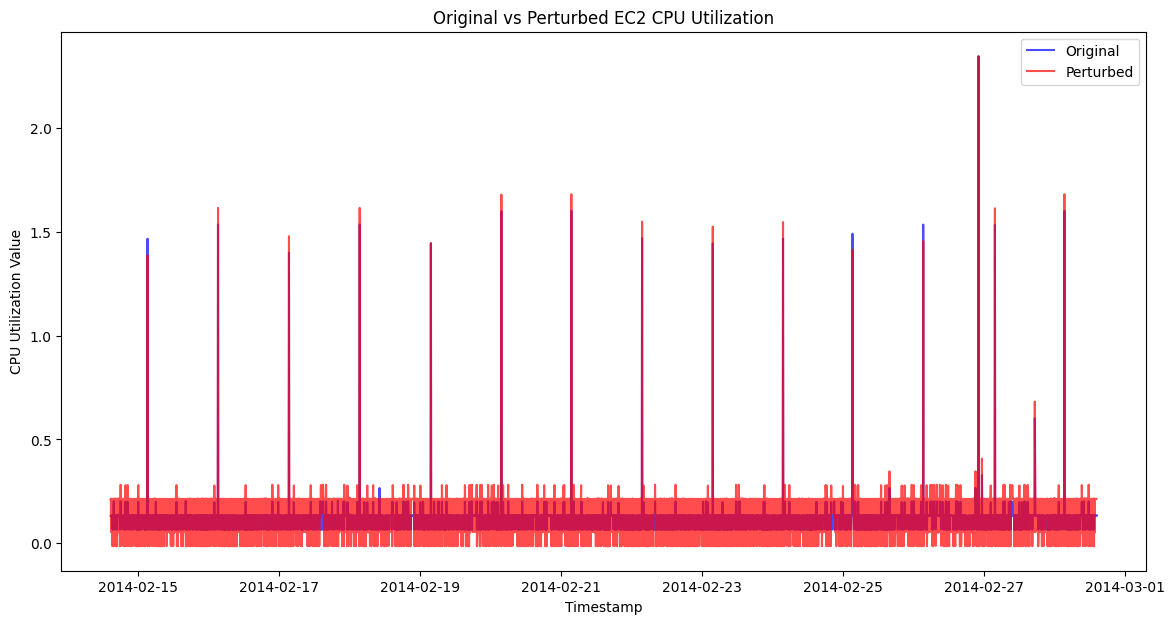

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the original and perturbed datasets
original_data = pd.read_csv('/content/ec2_cpu_utilization_24ae8d.csv', parse_dates=['timestamp'], index_col='timestamp')
perturbed_data = pd.read_csv('/content/EC2CPUUtilizationDataset_perturbed.csv', parse_dates=['timestamp'], index_col='timestamp')

# Plot both datasets on the same graph
plt.figure(figsize=(14, 7))
plt.plot(original_data.index, original_data['value'], label='Original', color='blue', alpha=0.7)
plt.plot(perturbed_data.index, perturbed_data['value'], label='Perturbed', color='red', alpha=0.7)

# Customize plot
plt.title("Original vs Perturbed EC2 CPU Utilization")
plt.xlabel("Timestamp")
plt.ylabel("CPU Utilization Value")
plt.legend()
plt.show()


In [ ]:
# Hardcoded parameters
workers = 4
batch_size = 64
use_cuda = True
checkpoint_path = '/content/drive/MyDrive/model_checkpoint.pth'  # Update with your checkpoint path
gpu_id = '0'
trials = 1
window_length = 2
n = 5  # Number of continuous windows with p-value < epsilon to detect OODness in the trace
seed = 100
save_dir = '/content/results'
dataset_path = '/content/EC2CPUUtilizationDataset_perturbed.csv'  # Update with your dataset path
transformation_list = ["low_pass", "high_pass", "dilation", "erosion", "identity"]

In [ ]:
# Set the model to evaluation mode
model.eval()

In [ ]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from scipy.ndimage import maximum_filter1d, minimum_filter1d
import random

class EC2CPUUtilizationDataset(Dataset):
    """EC2 CPU Utilization Dataset for anomaly detection"""
    def __init__(self, file_path, win_len=64, transformation_list=None, train=True):
        self.file_path = file_path
        self.win_len = win_len
        self.transformation_list = transformation_list or ["low_pass", "high_pass", "dilation", "erosion", "identity"]
        self.num_classes = len(self.transformation_list)
        self.traces = self.load_data()

    def load_data(self):
        data = pd.read_csv(self.file_path, parse_dates=['timestamp'], index_col='timestamp')
        values = data['value'].values
        traces = [values[i:i + self.win_len] for i in range(len(values) - self.win_len)]
        return traces

    def transform_win(self, win):
        trans_win = torch.FloatTensor(win)
        trans_win = trans_win.unsqueeze(0)  # Make it 3D for model compatibility
        return trans_win

    def __len__(self):
        return len(self.traces)

    def __getitem__(self, idx):
        tracedata = self.traces[idx]
        orig_win = tracedata.copy()
        trans_win = tracedata.copy()

        transform_id = random.randint(0, self.num_classes - 1)
        if self.transformation_list[transform_id] == "low_pass":
            trans_win = self.apply_filter_on_1D_data(trans_win, [1/3, 1/3, 1/3])
        elif self.transformation_list[transform_id] == "high_pass":
            trans_win = self.apply_filter_on_1D_data(trans_win, [-1/2, 0, 1/2])
        elif self.transformation_list[transform_id] == "dilation":
            trans_win = self.apply_dilation(trans_win, filter_size=3)
        elif self.transformation_list[transform_id] == "erosion":
            trans_win = self.apply_erosion(trans_win, filter_size=3)

        # Adjust the length of trans_win to match win_len
        trans_win = self.adjust_length(trans_win)

        # Convert to tensors and reshape
        trans_win = self.transform_win(trans_win)
        orig_win = self.transform_win(orig_win)

        return orig_win, trans_win, transform_id

    def adjust_length(self, sequence):
        """Adjust sequence length to match win_len by padding or truncating."""
        sequence = np.array(sequence)
        if len(sequence) < self.win_len:
            # Pad with the last value if sequence is too short
            padding = np.full(self.win_len - len(sequence), sequence[-1])
            sequence = np.concatenate([sequence, padding])
        elif len(sequence) > self.win_len:
            # Truncate if sequence is too long
            sequence = sequence[:self.win_len]
        return sequence

    def apply_filter_on_1D_data(self, input_data, filter_coeffs):
        input_data = np.array(input_data).flatten()
        return np.convolve(input_data, filter_coeffs, 'same')

    def apply_dilation(self, input_data, filter_size):
        return maximum_filter1d(input_data, size=filter_size, mode='nearest')

    def apply_erosion(self, input_data, filter_size):
        return minimum_filter1d(input_data, size=filter_size, mode='nearest')

In [ ]:
perturbed_dataset = EC2CPUUtilizationDataset(
    file_path="/content/EC2CPUUtilizationDataset_perturbed.csv",
    win_len=window_length,
    transformation_list=transformation_list
)

### NCM: Cross-Entropy Loss

In [ ]:
import torch
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

# Assuming `dataset` is the original dataset and `perturbed_dataset` is the perturbed dataset

# Define parameters
seed = 42
batch_size = 64
workers = 2
save_dir = './results'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the original and perturbed datasets
# Use original dataset as both calibration and in-distribution data
cal_dataset = dataset  # Original dataset
in_test_dataset = dataset  # Original dataset

# Use perturbed dataset as out-of-distribution data
out_test_dataset = perturbed_dataset

# Create DataLoaders
cal_dataloader = DataLoader(cal_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
in_test_dataloader = DataLoader(in_test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
out_test_dataloader = DataLoader(out_test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Function to calculate cross-entropy loss for each sample in the dataset
def calculate_ce_loss(model, dataloader):
    model.eval()
    total_loss = []
    with torch.no_grad():
        for orig_data, trans_data, label in dataloader:
            orig_data, trans_data, label = orig_data.to(device), trans_data.to(device), label.to(device)
            output = model(orig_data, trans_data)
            loss = criterion(output, label)
            total_loss.append(loss.item())
    return np.array(total_loss)

# Calculate CE loss for calibration set
cal_ce_loss = calculate_ce_loss(model, cal_dataloader)
print("Calibration CE Loss:", cal_ce_loss)
#np.save(os.path.join(save_dir, 'cal_ce_loss.npy'), cal_ce_loss)

# Calculate CE loss for in-distribution test set
in_test_ce_loss = calculate_ce_loss(model, in_test_dataloader)
print("In-distribution CE Loss:", in_test_ce_loss)
#np.save(os.path.join(save_dir, 'in_test_ce_loss.npy'), in_test_ce_loss)

# Calculate CE loss for out-of-distribution test set
out_test_ce_loss = calculate_ce_loss(model, out_test_dataloader)
print("Out-of-distribution CE Loss:", out_test_ce_loss)
#np.save(os.path.join(save_dir, 'out_test_ce_loss.npy'), out_test_ce_loss)

# Function to calculate p-values
def calc_p_value(test_loss, cal_losses):
    cal_losses_sorted = np.sort(cal_losses)
    p_value = (cal_losses_sorted >= test_loss).sum() / len(cal_losses_sorted)
    return p_value

# Calculate p-values for in-distribution and out-of-distribution test sets
in_p_values = np.array([calc_p_value(loss, cal_ce_loss) for loss in in_test_ce_loss])
out_p_values = np.array([calc_p_value(loss, cal_ce_loss) for loss in out_test_ce_loss])

# Evaluate AUROC
labels = np.concatenate([np.zeros(len(out_p_values)), np.ones(len(in_p_values))])
scores = np.concatenate([out_p_values, in_p_values])
auroc = roc_auc_score(labels, scores)
print(f'AUROC: {auroc * 100:.2f}%')




Calibration CE Loss: [0.30418685 0.23234655 0.2772043  0.29798308 0.29379788 0.46648228
 0.14414604 0.28986931 0.15444842 0.29214126 0.28610554 0.31497085
 0.24527462 0.21832062 0.28245774 0.38468197 0.3343356  0.37613997
 0.33162686 0.28457341 0.22657722 0.27737263 0.35486913 0.2985234
 0.34222457 0.28745282 0.36744055 0.30324775 0.43030429 0.26625302
 0.310772   0.27495342 0.26468635 0.103737   0.23489459 0.31407967
 0.2435022  0.24749702 0.16315123 0.16892217 0.25930083 0.40252805
 0.28260568 0.22476649 0.22238693 0.38665378 0.37323877 0.24229325
 0.18885842 0.21826947 0.47283903 0.18407534 0.53961039 0.22427544
 0.27332932 0.21887025 0.20953061 0.16652191 0.31580654 0.34987295
 0.28279448 0.31790996 0.27939355]
In-distribution CE Loss: [0.39364383 0.33871576 0.31248906 0.22758113 0.36871684 0.28611994
 0.25469762 0.15425557 0.1779183  0.21984152 0.21795267 0.25443467
 0.26386529 0.29361558 0.38072741 0.36689797 0.23958902 0.29988736
 0.21397729 0.32127276 0.15664917 0.19887845 0.24

### NCM: Activation

In [ ]:
import numpy as np

# Extract model outputs
def extract_model_outputs(dataloader, model):
    model.eval()
    model_outputs = []

    with torch.no_grad():
        for orig_data, trans_data, label in dataloader:
            orig_data = orig_data.to(device)
            trans_data = trans_data.to(device)

            # Get model outputs (fc2(x))
            activation,outputs = model(orig_data, trans_data,last=True)
            model_outputs.append(activation.cpu().numpy())

    return np.concatenate(model_outputs, axis=0)

# Compute percentile-based thresholds for model outputs
def compute_percentile_thresholds(dataloader, model, lower_percentile=2.5, upper_percentile=97.5):
    model_outputs = extract_model_outputs(dataloader, model)
    lower_bounds = np.percentile(model_outputs, lower_percentile, axis=0)
    upper_bounds = np.percentile(model_outputs, upper_percentile, axis=0)
    return lower_bounds, upper_bounds

# Calculate nonconformity scores based on output thresholds
def calculate_nonconformity_score_percentile(dataloader, model, lower_bounds, upper_bounds):
    model_outputs = extract_model_outputs(dataloader, model)
    # Proportion of outputs outside the percentile-based thresholds
    out_of_bounds = np.sum((model_outputs < lower_bounds) | (model_outputs > upper_bounds), axis=1)
    return out_of_bounds / model_outputs.shape[1]

# Calibration phase: Compute percentile thresholds
lower_bounds, upper_bounds = compute_percentile_thresholds(cal_dataloader, model)

# Calculate nonconformity scores for calibration, in-distribution, and out-of-distribution datasets
cal_nonconformity_scores = calculate_nonconformity_score_percentile(cal_dataloader, model, lower_bounds, upper_bounds)
in_test_nonconformity_scores = calculate_nonconformity_score_percentile(in_test_dataloader, model, lower_bounds, upper_bounds)
out_test_nonconformity_scores = calculate_nonconformity_score_percentile(out_test_dataloader, model, lower_bounds, upper_bounds)

# Update p-value calculation
def calc_p_value(test_score, cal_scores):
    cal_scores_sorted = np.sort(cal_scores)
    p_value = (cal_scores_sorted >= test_score).sum() / len(cal_scores_sorted)
    return p_value

# Calculate p-values for in-distribution and out-of-distribution test sets
in_p_values = np.array([calc_p_value(score, cal_nonconformity_scores) for score in in_test_nonconformity_scores])
out_p_values = np.array([calc_p_value(score, cal_nonconformity_scores) for score in out_test_nonconformity_scores])

# Evaluate AUROC
labels = np.concatenate([np.zeros(len(out_p_values)), np.ones(len(in_p_values))])
scores = np.concatenate([out_p_values, in_p_values])
auroc = roc_auc_score(labels, scores)
print(f'AUROC: {auroc * 100:.2f}%')


AUROC: 85.10%


### Baseline

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
import os

# Hardcoded configuration
config = {
    'window_length': 2,  # Set sliding window length
    'root_dir': '/content/EC2CPUUtilizationDataset_perturbed.csv',  # Update this path as per your Colab setup
}

# Load the EC2 CPU Utilization dataset
data = pd.read_csv(config['root_dir'])
perturbed_data = pd.read_csv('/content/EC2CPUUtilizationDataset_perturbed.csv')
data=pd.concat([data,perturbed_data])
# Extract timestamps and CPU utilization values
timestamps = data['timestamp'].values  # Timestamp column (can be ignored if not required for model)
cpu_values = data['value'].values  # CPU utilization values column

# Normalize CPU utilization values
scaler = preprocessing.StandardScaler()
cpu_values = scaler.fit_transform(cpu_values.reshape(-1, 1)).flatten()

# Create sliding windows for the dataset
def create_sliding_windows(data, window_length):
    windows = []
    for start in range(len(data) - window_length + 1):
        windows.append(data[start:start + window_length])
    return np.array(windows)

# Prepare training and testing windows (Assume last 10% is OOD test data)
window_length = config['window_length']
windows = create_sliding_windows(cpu_values, window_length)

# Split into training and testing data
split_index = int(0.5 * len(windows))
training_windows = windows[:split_index]
testing_windows = windows[split_index:]

# Compute auto-correlation for windows
def compute_autocorrelation(data):
    correlated_data = []
    for win in data:
        cor_data = np.correlate(win, win, mode='full')[len(win) - 1:]  # Auto-correlation
        correlated_data.append(cor_data)
    return np.array(correlated_data)

# Auto-correlation for training and testing windows
correlated_training_windows = compute_autocorrelation(training_windows)
correlated_testing_windows = compute_autocorrelation(testing_windows)

# Scaling the data
scaler = preprocessing.StandardScaler().fit(correlated_training_windows)
correlated_training_windows = scaler.transform(correlated_training_windows)
correlated_testing_windows = scaler.transform(correlated_testing_windows)

# Train one-class SVM
clf = OneClassSVM().fit(correlated_training_windows)
training_scores = clf.predict(correlated_training_windows)
testing_scores = clf.predict(correlated_testing_windows)

# AUROC and TNR calculation functions
def getAUROC(in_scores, out_scores):
    all_scores = np.concatenate((in_scores, out_scores))
    labels = np.concatenate((np.ones(len(in_scores)), np.zeros(len(out_scores))))
    from sklearn.metrics import roc_auc_score
    return roc_auc_score(labels, all_scores) * 100

def getTNR(in_scores, out_scores):
    sorted_in_scores = np.sort(in_scores)[::-1]
    tau = sorted_in_scores[int(0.95 * len(in_scores))]
    return 100 * (len(out_scores[out_scores < tau]) / len(out_scores))

# Assume last 10% of the dataset as OOD data
au_roc = getAUROC(training_scores, testing_scores)
tnr = getTNR(training_scores, testing_scores)

print(f"AUROC: {au_roc:.2f}")
print(f"TNR: {tnr:.2f}")


AUROC: 49.99
TNR: 0.00
